# **GradCAM and LLM: Unveiling the Secrets of Model Decision-Making.**
This notebook corresponds to the homonymous report and serves as the implementation section of the project. It is structured into six main phases:

- **Model Loading:** TThe Vit model, created for the project described in the article "[Identifying AI-Generated Art with Deep Learning](https://www.researchgate.net/publication/375116319_Identifying_AI-Generated_Art_with_Deep_Learning)", has been loaded and applied to images from the respective dataset for training and prediction.
  
- **Grad-CAM Application:** Grad-CAM has been applied to a subset of the images of interest derived from the dataset referenced in the article.
  
- **Application of Various LLMs:** LLaVa-NeTx, InstructBLIB, and KOSMOS-2 were employed to generate explanations for points of interest identified by the classifier and represented using GradMap.
  
- **Results Evaluation**
  
- **Results Visualization**


##  *First part: Model Loading*
We will use a Vision Transformer (ViT) model, which, through a fine-tuning phase, has been specialized to classify works of art as either "Original" or "AI-generated."

In [ ]:
import torch
import torch.nn as nn
import shutil
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset,DataLoader,random_split
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
from PIL import Image,ImageFile
import torch.optim as optim
import pandas as pd
import copy
from torch.optim import lr_scheduler
from google.colab import drive
drive.mount('/content/drive')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cuda


In [ ]:
! unzip "/content/drive/My Drive/Finetuning_Artwork_models/Dataset_arte_fake.zip"

In [ ]:
! unzip "/content/drive/My Drive/Finetuning_Artwork_models/Dataset_arte_vera.zip"

Output streaming troncato alle ultime 5000 righe.
  inflating: Dataset_arte_vera/nikolay-bogdanov-belsky_teacher-s-birthday.jpg  
  inflating: Dataset_arte_vera/nikolay-bogdanov-belsky_teacher-s-birthday-1.jpg  
  inflating: Dataset_arte_vera/nikolay-bogdanov-belsky_the-farm.jpg  
  inflating: Dataset_arte_vera/nikolay-bogdanov-belsky_the-former-defender-of-the-homeland.jpg  
  inflating: Dataset_arte_vera/nikolay-bogdanov-belsky_the-wood.jpg  
  inflating: Dataset_arte_vera/nikolay-bogdanov-belsky_three-boys-in-the-wood.jpg  
  inflating: Dataset_arte_vera/nikolay-bogdanov-belsky_toadstools-under-the-tree.jpg  
  inflating: Dataset_arte_vera/nikolay-bogdanov-belsky_to-school.jpg  
  inflating: Dataset_arte_vera/nikolay-bogdanov-belsky_to-work.jpg  
  inflating: Dataset_arte_vera/nikolay-bogdanov-belsky_two-girls-on-a-footbridge.jpg  
  inflating: Dataset_arte_vera/nikolay-bogdanov-belsky_vase-of-flowers-in-the-winter-garden.jpg  
  inflating: Dataset_arte_vera/nikolay-bogdanov-belsky_

In [ ]:
#Inserire i due folder(real e fake) in una nuova cartella

fake_dir = 'Dataset_arte_fake'
real_dir = 'Dataset_arte_vera'

os.mkdir("Artworks")

shutil.move(fake_dir,'Artworks')
shutil.move(real_dir,'Artworks')


In [ ]:
#Classe per gestire gli artwork rispetto alla loro autenticità

class ArtworkDataset(Dataset):
  def __init__(self,links,transform):
      self.data = links
      self.transform = transform

  def __len__(self):
    return self.data.index.shape[0]

  def __getitem__(self,idx):
        img = Image.open(self.data.iloc[idx,0])
        label_index = self.data.iloc[idx, 1]
        if (img.mode != 'RGB'):
            img = img.convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label_index


In [ ]:
# Creazione del csv contenente il path degli artwork e l'autenticità

path = 'Artworks'

data = [] # Crea una lista vuota per immagazinare i percorsi degli artwork e le etichette (real o fake)

# Cicla la cartella degli artwork falsi e aggiunge il percorso e l'etichetta alla lista "data"

for dirpath, dirnames, filenames in os.walk(os.path.join(path,fake_dir)):
    for filename in filenames:
        if filename.endswith(".jpg"): # only consider jpg files
            filepath = os.path.join(dirpath, filename)
            data.append((filepath, "0"))


# Cicla la cartella degli artwork vero e aggiunge il percorso e l'etichetta alla lista "data"

for filename in os.listdir(os.path.join(path,real_dir)):
    if filename.endswith(".jpg"):
       filepath = os.path.join(path,real_dir,filename)
       data.append((filepath,"1"))

# Converte la lista "data" in un dataframe pandas
df = pd.DataFrame(data, columns=["path", "label"])

# Salva il dataframe in un file csv
df.to_csv("image_labels.csv", index=False)


In [ ]:
!pip install timm
import timm

model = timm.create_model('vit_small_patch16_224',pretrained=True, num_classes=2)

model = model.to(device)
print(model)

In [ ]:
#Pesi di tutti i modelli resi non allenabili
for param in model.parameters():
    param.requires_grad = False


In [ ]:
#Reso allenabile l'ultimo layer del modello
for p in model.head.parameters():
    p.requires_grad=True

In [ ]:
dataset = df
dataset['label'] = dataset['label'].astype(int)
dataset

In [ ]:
# Dividi il dataset in due parti (training + validation e test)
train_val_data, test = train_test_split(dataset.values, test_size=0.1, random_state=1)

# Dividi la parte di training + validation nei set di training e validation
train, validation = train_test_split(train_val_data, test_size=0.1, random_state=1)

In [ ]:
train_links = pd.DataFrame(train, columns = dataset.columns)
validation_links = pd.DataFrame(validation, columns = dataset.columns)
test_links = pd.DataFrame(test, columns = dataset.columns)

In [ ]:
data_transforms = transforms.Compose([
                                transforms.Resize(224),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))


])



batch_size = 32

train_set = ArtworkDataset( train_links, data_transforms)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                               drop_last=False,num_workers=2)

validation_set = ArtworkDataset( validation_links, data_transforms)

validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True,
                               drop_last=False,num_workers=2)

test_set = ArtworkDataset( test_links,data_transforms)

test_loader = DataLoader(test_set,batch_size=batch_size, shuffle = True,
                              drop_last=False,num_workers=2)


In [ ]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0.001):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.wait = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, current_loss):
        if self.best_loss == None:
            self.best_loss = current_loss
        elif (current_loss - self.best_loss) < -self.min_delta:
            self.best_loss = current_loss
            self.wait = 0
            torch.save(model.state_dict(),'RealArt_vs_FakeArt_vit_small_patch16_224.pt')
            if os.path.exists('/content/drive/My Drive/Finetuning_Artwork_models/Modelli/RealArt_vs_FakeArt_vit_small_patch16_224.pt'):
               os.remove('/content/drive/My Drive/Finetuning_Artwork_models/Modelli/RealArt_vs_FakeArt_vit_small_patch16_224.pt')
               shutil.move('RealArt_vs_FakeArt_vit_small_patch16_224.pt','/content/drive/My Drive/Finetuning_Artwork_models/Modelli')
            else:
               shutil.move('RealArt_vs_FakeArt_vit_small_patch16_224.pt','/content/drive/My Drive/Finetuning_Artwork_models/Modelli')

        else:
            self.wait = self.wait + 1
            print(f"INFO: Early stopping counter {self.wait} of {self.patience}")
            if self.wait >= self.patience:
                self.early_stop = True

In [ ]:
def fine_tune(model, train_loader, validation_loader, criterion, optimizer, scheduler, early_stop ,num_epochs = 100):
    best_model = copy.deepcopy(model)
    best_acc = 0.0
    best_epoch=0
    stop = False

    for epoch in range(1, num_epochs + 1):
        if stop:
            break
        print(f'Epoch {epoch}/{num_epochs}')
        print('-'*120)

        data_loader = None
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                data_loader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                data_loader = validation_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(data_loader):

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs = nn.Softmax(dim = 1)(outputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / (len(data_loader) * data_loader.batch_size)
            epoch_acc = running_corrects.double() / (len(data_loader) * data_loader.batch_size)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch = epoch
                best_model = copy.deepcopy(model)


            if phase == 'val':
                early_stop(epoch_loss)
                print('-'*120, end = '\n\n')
                stop=early_stop.early_stop


    print(f'Best val Acc: {best_acc:4f}')
    print(f'Best epoch: {best_epoch:03d}')

    # load best model
    return best_model

In [ ]:
if not 'RealArt_vs_FakeArt_vit_small_patch16_224.pt' in os.listdir():
   criterion = nn.CrossEntropyLoss()
   optimizer = optim.Adam(model.parameters(), lr=1e-3)
   scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
   early_stop= EarlyStopping(patience = 3, min_delta = 0.001)
   ImageFile.LOAD_TRUNCATED_IMAGES = True
   best_model_head=fine_tune(model, train_loader, validation_loader, criterion, optimizer, scheduler, early_stop, num_epochs = 30)
   torch.save(best_model_head, 'RealArt_vs_FakeArt_vit_small_patch16_224.pt')
   if os.path.exists('/content/drive/My Drive/Finetuning_Artwork_models/Modelli/RealArt_vs_FakeArt_vit_small_patch16_224.pt'):
               os.remove('/content/drive/My Drive/Finetuning_Artwork_models/Modelli/RealArt_vs_FakeArt_vit_small_patch16_224.pt')
               shutil.move('RealArt_vs_FakeArt_vit_small_patch16_224.pt','/content/drive/My Drive/Finetuning_Artwork_models/Modelli')
   else:
               shutil.move('RealArt_vs_FakeArt_vit_small_patch16_224.pt','/content/drive/My Drive/Finetuning_Artwork_models/Modelli')

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# funzione per il testing del modello
def test_model(model, test_loader):
    model.eval() # imposto il modello in modalità di valutazione
    test_loss = 0
    correct = 0
    pred_list = []
    true_list = []
    # inizializza la barra di avanzamento
    pbar = tqdm(total=len(test_loader))

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # sommo il loss di ogni batch

            pred = output.argmax(dim=1, keepdim=True) # ottengo la predizione del modello
            pred_list.extend(pred.cpu().numpy()) # aggiungo la predizione alla lista
            true_list.extend(target.cpu().numpy()) # aggiungo il target alla lista

            correct += pred.eq(target.view_as(pred)).sum().item() # aggiorno il contatore di classificazioni corrette
            # aggiorna la barra di avanzamento
            pbar.update(1)
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    recall = recall_score(true_list, pred_list, average='macro') # calcolo la recall
    precision = precision_score(true_list, pred_list, average='macro') # calcolo la precision
    f1 = f1_score(true_list, pred_list, average='macro') # calcolo la F1 score
    auc = roc_auc_score(true_list, pred_list) # calcolo l'AUC

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%), Recall: {:.2f}%, Precision: {:.2f}%, F1: {:.2f}%, AUC: {:.2f}%\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy, recall*100, precision*100, f1*100, auc*100))

    return accuracy, recall, precision, f1, auc

In [ ]:
accuracy,recall,precision,f1,auc = test_model(model,test_loader)

## *Second part: GradCAM*

Grad-CAM (Gradient-weighted Class Activation Mapping) is a visualization technique used to understand and interpret the decisions made by deep learning **models**. By introducing weighted activation maps, Grad-CAM highlights the regions of an image that contributed the most to the model's final decision. This technique helps reveal how the model "sees" the image and what visual features it uses for classification or prediction. Grad-CAM is a valuable tool in explainable artificial intelligence (XAI) as it provides a more transparent view of the model's decision-making process, making neural networks more interpretable and reliable. Consequently, we apply the Grad-CAM technique to a subset of images from the relevant dataset to obtain the activation maps.

--------------- Repetead part ---------------

In [ ]:
import torch
import torchvision
from torchvision import transforms
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
!pip install timm

import timm
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 12.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
! unzip "/content/drive/My Drive/Finetuning_Artwork_models/Dataset_arte_fake.zip"

Output streaming troncato alle ultime 5000 righe.
  inflating: Dataset_arte_fake/stylegan3-t-metfacesu-1024x1024/img003000.jpg  
  inflating: Dataset_arte_fake/stylegan3-t-metfacesu-1024x1024/img003001.jpg  
  inflating: Dataset_arte_fake/stylegan3-t-metfacesu-1024x1024/img003002.jpg  
  inflating: Dataset_arte_fake/stylegan3-t-metfacesu-1024x1024/img003003.jpg  
  inflating: Dataset_arte_fake/stylegan3-t-metfacesu-1024x1024/img003004.jpg  
  inflating: Dataset_arte_fake/stylegan3-t-metfacesu-1024x1024/img003005.jpg  
  inflating: Dataset_arte_fake/stylegan3-t-metfacesu-1024x1024/img003006.jpg  
  inflating: Dataset_arte_fake/stylegan3-t-metfacesu-1024x1024/img003007.jpg  
  inflating: Dataset_arte_fake/stylegan3-t-metfacesu-1024x1024/img003008.jpg  
  inflating: Dataset_arte_fake/stylegan3-t-metfacesu-1024x1024/img003009.jpg  
  inflating: Dataset_arte_fake/stylegan3-t-metfacesu-1024x1024/img003010.jpg  
  inflating: Dataset_arte_fake/stylegan3-t-metfacesu-1024x1024/img003011.jpg  
  

In [ ]:
! unzip "/content/drive/My Drive/Finetuning_Artwork_models/Dataset_arte_vera.zip"

Output streaming troncato alle ultime 5000 righe.
  inflating: Dataset_arte_vera/thomas-gainsborough_the-linley-sisters-mrs-sheridan-and-mrs-tickell-1772.jpg  
  inflating: Dataset_arte_vera/thomas-gainsborough_the-market-cart-1786.jpg  
  inflating: Dataset_arte_vera/thomas-gainsborough_the-three-eldest-daughters-of-george-iii-princesses-charlotte-augusta-and-elizabeth-1784.jpg  
  inflating: Dataset_arte_vera/thomas-gainsborough_thomas-pennant-1776.jpg  
  inflating: Dataset_arte_vera/thomas-gainsborough_william-poyntz-of-midgham-and-his-dog-amber-1762.jpg  
  inflating: Dataset_arte_vera/thomas-gainsborough_wooded-landscape-with-a-waggon-in-the-shade.jpg  
  inflating: Dataset_arte_vera/thomas-gainsborough_wooded-landscape-with-cattle-by-a-pool-and-a-cottage-at-evening-1782.jpg  
  inflating: Dataset_arte_vera/thomas-girtin_a-gateway-with-two-round-towers-1797.jpg  
  inflating: Dataset_arte_vera/thomas-girtin_a-lake-and-mountains-in-westmorland-1797.jpg  
  inflating: Dataset_arte_

In [ ]:
#Inserire i due folder(real e fake) in una nuova cartella
import os
import shutil

fake_dir = 'Dataset_arte_fake'
real_dir = 'Dataset_arte_vera'

os.mkdir("Artworks")

shutil.move(fake_dir,'Artworks')
shutil.move(real_dir,'Artworks')

'Artworks/Dataset_arte_vera'

In [ ]:
#Classe per gestire gli artwork rispetto alla loro autenticità
from torch.utils.data import Dataset

class ArtworkDataset(Dataset):
  def __init__(self,links,transform):
      self.data = links
      self.transform = transform

  def __len__(self):
    return self.data.index.shape[0]

  def __getitem__(self,idx):
        img = Image.open(self.data.iloc[idx,0])
        label_index = self.data.iloc[idx, 1]
        if (img.mode != 'RGB'):
            img = img.convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label_index


In [ ]:
import pandas as pd

# Creazione del dataframe contenente il path degli artwork e l'autenticità

path = 'Artworks'

data = [] # Crea una lista vuota per immagazinare i percorsi degli artwork e le etichette (real o fake)

# Cicla la cartella degli artwork falsi e aggiunge il percorso e l'etichetta alla lista "data"

for dirpath, dirnames, filenames in os.walk(os.path.join(path,fake_dir)):
    for filename in filenames:
        if filename.endswith(".jpg"): # only consider jpg files
            filepath = os.path.join(dirpath, filename)
            data.append((filepath, "0"))


# Cicla la cartella degli artwork veri e aggiunge il percorso e l'etichetta alla lista "data"

for filename in os.listdir(os.path.join(path,real_dir)):
    if filename.endswith(".jpg"):
       filepath = os.path.join(path,real_dir,filename)
       data.append((filepath,"1"))

# Converte la lista "data" in un dataframe pandas
df = pd.DataFrame(data, columns=["path", "label"])

# Salva il dataframe in un file csv
df.to_csv("image_labels.csv", index=False)

In [ ]:
from sklearn.model_selection import train_test_split

df['label'] = df['label'].astype(int)

# Dividi il dataset in due parti (training + validation e test)
train_val_data, test = train_test_split(df.values, test_size=0.1, random_state=1)

for file_path, label in test:
    print(file_path)

Output streaming troncato alle ultime 5000 righe.
Artworks/Dataset_arte_fake/stylegan3-r-metfaces-1024x1024/img003539.jpg
Artworks/Dataset_arte_vera/boris-kustodiev_england-1924.jpg
Artworks/Dataset_arte_vera/zdislav-beksinski_untitled-387.jpg
Artworks/Dataset_arte_fake/photo2monet/img012515.jpg
Artworks/Dataset_arte_vera/utagawa-kuniyoshi_view-of-mt-fuji-3.jpg
Artworks/Dataset_arte_vera/julio-romero-de-torres_c-rdoba-1913.jpg
Artworks/Dataset_arte_vera/filippo-brunelleschi_sketches-of-the-machines-1.jpg
Artworks/Dataset_arte_fake/stylegan3-t-metfacesu-1024x1024/img004531.jpg
Artworks/Dataset_arte_vera/rainer-fetting_bianca-1982.jpg
Artworks/Dataset_arte_fake/stylegan3-r-metfaces-1024x1024/img003749.jpg
Artworks/Dataset_arte_fake/stylegan3-r-metfaces-1024x1024/img007261.jpg
Artworks/Dataset_arte_fake/stylegan3-t-metfaces-1024x1024/img003531.jpg
Artworks/Dataset_arte_fake/stylegan3-r-metfacesu-1024x1024/img007490.jpg
Artworks/Dataset_arte_fake/art_painting/img000446.jpg
Artworks/Dataset

--------------- End Repetead part ---------------

*Implementation of GradCAM*

In [ ]:
def preprocess_image(image_path,model_name):
    img = Image.open(image_path)
    if model_name == 'vgg19':
       preprocess = transforms.Compose([
           transforms.Resize(256),
           transforms.CenterCrop(256),
           transforms.ToTensor(),
           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
       ])
    else:
       preprocess = transforms.Compose([
           transforms.Resize(224),
           transforms.CenterCrop(224),
           transforms.ToTensor(),
           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    img_tensor = preprocess(img).unsqueeze(0)
    return img_tensor.to(device)

In [ ]:
class GradCAM:
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.model.eval()


    def save_gradient(self, grad):
        self.gradients = grad

    def forward(self, x):
        self.model.zero_grad()
        x.requires_grad_()
        out = self.model(x)
        return out

    def generate_cam(self, image_tensor, target_class):
        output = self.forward(image_tensor)
        one_hot_output = torch.zeros((1, output.size()[-1]), dtype=torch.float)
        one_hot_output[0][target_class] = 1
        one_hot_output= one_hot_output.to(device)
        output.backward(gradient=one_hot_output)
        gradients = self.gradients.detach().cpu().numpy()
        feature_maps = self.model.feature_maps.detach().cpu().numpy()
        cam_weights = np.mean(gradients, axis=(2, 3))[0, :]
        cam = np.zeros(feature_maps.shape[2:], dtype=np.float32)

        for i, weight in enumerate(cam_weights):
            cam += weight * feature_maps[0, i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)

        return cam

In [ ]:
def register_hooks(model, grad_cam):
    def forward_hook(module, input, output):
        grad_cam.model.feature_maps = output

    def backward_hook(module, grad_input, grad_output):
        grad_cam.save_gradient(grad_output[0])

    for name, module in model.named_modules():
        if isinstance(module, torch.nn.modules.conv.Conv2d):
            target_module = module
    target_module.register_forward_hook(forward_hook)
    target_module.register_backward_hook(backward_hook)

In [ ]:
def apply_grad_cam(image_path, model, grad_cam,model_name):

    # Carica ed effettua il preprocessing dell'immagine
    image_tensor = preprocess_image(image_path,model_name)


    # Registra gli hooks per Grad-CAM
    register_hooks(model, grad_cam)


    # Ottiene la predizione dal modello
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        top_prob, top_class = probabilities.topk(1, dim=1)

    # Generazione di Grad-CAM
    cam = grad_cam.generate_cam(image_tensor, top_class.item())


    # Carica l'immagine originale e sovrappone Grad-CAM
    original_image = cv2.imread(image_path)
    original_image = cv2.resize(original_image, (224, 224))
    cam_heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    cam_heatmap = cv2.cvtColor(cam_heatmap, cv2.COLOR_BGR2RGB)
    overlayed_image = cv2.addWeighted(original_image, 0.5, cam_heatmap, 0.5, 0)

    return top_class.item(), top_prob.item(), cam_heatmap, overlayed_image


In [ ]:
def visualize_results(image_path, model, grad_cam,model_name):


    top_class, top_prob, cam_heatmap, overlayed_image = apply_grad_cam(image_path, model, grad_cam,model_name)
    labels=["fake","real"]
    class_label = labels[top_class]

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    print(model_name,'\n')
    ax[0].imshow(Image.open(image_path))
    ax[0].axis('off')
    ax[0].set_title('Original Image')

    ax[1].imshow(cam_heatmap)
    ax[1].axis('off')
    ax[1].set_title('Grad-CAM Heatmap')

    ax[2].imshow(overlayed_image)
    ax[2].axis('off')
    ax[2].set_title(f'Overlayed Image (Class: {class_label}, Prob: {top_prob:.4f})')

    plt.show()


In [ ]:
import timm.models.layers

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#resnet50 = torch.load('/content/drive/My Drive/Finetuning_Artwork_models/Modelli/RealArt_vs_FakeArt_resnet50.pt', map_location=device)
#vgg19 = torch.load('/content/drive/My Drive/Finetuning_Artwork_models/Modelli/RealArt_vs_FakeArt_vgg19.pt', map_location=device)
vit = torch.load('/content/drive/My Drive/Finetuning_Artwork_models/Modelli/RealArt_vs_FakeArt_vit_small_patch16_224.pt', map_location=device)
#resnet50 = resnet50.to(device)
#vgg19 = vgg19.to(device)
vit = vit.to(device)
#resnet50.eval()
#vgg19.eval()
vit.eval()

In [ ]:
def Output_grad_cam(image_path):
    #grad_cam = GradCAM(resnet50)
    #visualize_results(image_path, resnet50, grad_cam,"resnet50")
    #ì#grad_cam = GradCAM(vgg19)
    #visualize_results(image_path, vgg19, grad_cam,"vgg19")
    grad_cam = GradCAM(vit)
    visualize_results(image_path, vit, grad_cam,"vit")

### Visualization of Artwork

Let's now visualize the results of the processing done so far. In the first example, we have an image classified as 'Original,' the GradCAM showing where the network focused to classify it as such, and the two overlaid images.

In the second example, we find the same elements, but for an image classified as 'AI-Generated.'

In [ ]:
import cv2

# FIRST EXAMPLE
image_path = 'Artworks/Dataset_arte_vera/ossip-zadkine_study-of-women.jpg'
Output_grad_cam(image_path)

In [ ]:
# SECOND EXAMPLE
image_path = 'Artworks/Dataset_arte_fake/stylegan3-t-metfacesu-1024x1024/img002795.jpg'
Output_grad_cam(image_path)

Now that we have all the main components to enhance the explainability of the ViT's decision-making process, let's move on to the core of the project.

## *Third part: Application of Various LLMs*

Now, the objective of this phase is to generate explanations using various Large Language Models (LLMs) about the likely reasons why the ViT focused on the regions of maximum activation indicated by GradCAM to classify the image as original or AI-generated.

But before doing so, let's create a new dataset containing the image path, the path of the GradCAM-processed image, and its label generated by the ViT.


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('image_labels.csv')

#Let's select a subset of the main dataset by taking 50 original images and 50 AI-generated images.
true_img = df[df['label'] == 1][:50]
fake_img = df[df['label'] == 0][:50]

df_rid = pd.concat([true_img, fake_img], axis=0, ignore_index=True)

In [ ]:
import os
import cv2
import PIL.Image
from tqdm import tqdm


image_path = df_rid[['path','label']]
output_dir = "/content/GradCams_img"
index = 0

add = {"url_org": [],"url_map": [], "label": []}

grad_cam = GradCAM(vit)
model = vit

for p, label in tqdm(image_path.to_numpy()):

  _ , _ , _, overlayed_image = apply_grad_cam(p, model, grad_cam,"vit")

  if overlayed_image.shape[2] == 3 and overlayed_image[..., 0].mean() > overlayed_image[..., 2].mean():
      converted_image = overlayed_image
  else:
      converted_image = cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB)

  # Salvataggio delle immagini
  filename = f"overlayed_image_{index}.jpg"
  output_path = os.path.join(output_dir, filename)

  plt.imshow(overlayed_image)
  plt.axis('off')  # Remove axis
  plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
  plt.close()

  add["url_org"].append(p)
  add["url_map"].append(output_path)
  add["label"].append(label)

  index += 1

In [ ]:
ds = pd.DataFrame(add)
ds.to_csv('Dataset_url_map.csv', index=True)

In [ ]:
ds

In [ ]:
import shutil
from google.colab import files

folder_to_zip = '/content/GradCams_img'
output_filename = '/content/GradCams_img.zip'
shutil.make_archive(output_filename.replace('.zip', ''), 'zip', folder_to_zip)
files.download(output_filename)

### LLaVa-Next

The first model we used is LLava-Next.
LLava-Next is an advanced Large Language Model (LLM) designed for generating detailed and accurate descriptions of images. Leveraging state-of-the-art artificial intelligence technologies, LLava-Next can analyze the visual features of images and generate descriptive texts that capture both the key visual elements and the context of the image.

The LLava-Next model was proposed in "LLaVA-NeXT: Improved Reasoning, OCR, and World Knowledge" by Haotian Liu, Chunyuan Li, Yuheng Li, Bo Li, Yuanhan Zhang, Sheng Shen, and Yong Jae Lee. LLava-Next (also known as LLaVA-1.6) builds upon LLaVA by increasing the input image resolution and training on an enhanced visual instruction tuning dataset, thereby improving OCR and common sense reasoning.

In [ ]:
!pip install bitsandbytes
!pip install accelerate

In [ ]:
import requests
from transformers import LlavaNextForConditionalGeneration, BitsAndBytesConfig,LlavaNextProcessor
import torch

# specify how to quantize the model
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

model = LlavaNextForConditionalGeneration.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf", quantization_config=quantization_config, device_map="auto")
processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")

In [ ]:
def LLaVa_response(model, processor, img, label,lang):
  prompt = ""

  if lang == "it":
    if label == 1:
      label = "Originale"
    else:
      label = "Generato da AI"
    prompt = f" [INST] <image> L\'immagine rappresenta un\' opera d\' arte a cui è stata sovrapposta una mappa di attivazione generata da una CAM (Class Activation Mapping). Questa mappa consente di visualizzare le regioni dell\' opera su cui la rete ha basato la sua decisione di classificazione. In questo caso, la mappa sovrapposta all\' opera permette di associare all\' opera d\' arte la label \"Originale\" se non è stata generata artificialmente, o \"Generata da AI\" se è stata generata artificialmente. L\'opera sottostante alla mappa è stata classificata come \"{label}\". Descrivi cosa ha potuto far concentrare la rete in quelle aree specifiche dell\' opera per la classificazione. Dammi una risposta concisa che non spieghi la classificazione, ma solo il motivo ipotetico per la quale la rete si è concentrata in quelle aree. I colori rappresentano la mappa di attivazione generata dalla rete stessa, e sotto ai colori c'è il disegno originale. Non c'è nessun pubblico. La mappa rappresenta le aree su cui la rete si è concentrata di più per classificare l'opera. #ESEMPIO DI OUTPUT: L\'opera è stata classificata come Generata da AI perchè molto probabilmente le linee del disegno o i colori sono discordanti dai pattern rilevati.[/INST]"

  else:
    if label == 1:
      label = "Original"
    else:
      label = "Generated by AI"
    prompt =f" [INST] <image> This image depicts an artwork overlaid with a Class Activation Mapping (CAM) activation map. This map visualizes the regions of the artwork that the network relied on for its classification decision. In this case, the map overlaid on the artwork allows the artwork to be associated with the label \"Original\" if it was not artificially generated, or \"AI-Generated\" if it was artificially generated. The artwork underlying the map was classified as \" {label} \" Describe what could have caused the network to focus on those specific areas of the artwork for classification. Provide a concise response that does not explain the classification, but only the hypothetical reason why the network focused on those areas. The colors represent the activation map generated by the network itself, and below the colors is the original artwork. There is no audience. The map represents the areas on which the network focused the most to classify the artwork.Example Output: The artwork was classified as AI-Generated because the lines of the drawing or the colors are very likely discordant from the patterns detected.[/INST]"


  # Preprocess the image and text
  inputs = processor(images=img, text=prompt, return_tensors="pt").to("cuda:0")

  output = model.generate(**inputs, max_new_tokens=200)
  generated_text = processor.decode(output[0], skip_special_tokens=True)

  return generated_text.split("[/INST]")[-1].strip()

In [ ]:
import pandas as pd
import PIL.Image

index = 0
imgs = pd.read_csv('Dataset_url_map.csv')

add = {"LLaVa_desc": []}

for img in imgs.to_numpy():
  i = PIL.Image.open(img[2])

  generated_text = LLaVa_response(model,processor, i, img[3],"it")
  add["LLaVa_desc"].append(generated_text)
  index += 1

In [ ]:
add["LLaVa_desc"]
add

In [ ]:
lava = pd.DataFrame(add)
lava.to_csv('LLaVa_desc.csv', index=True)

### InstructBLIP

The second model We employed in the project was InstructBLIP, a vision-language model introduced in "InstructBLIP: Towards General-purpose Vision-Language Models with Instruction Tuning" by Wenliang Dai et al. Leveraging the BLIP-2 architecture, InstructBLIP is adept at understanding and following instructions, making it a valuable tool for my research.

In [ ]:
!pip install transformers
!pip install bitsandbytes
!pip install accelerate
!pip install pillow

In [ ]:
from transformers import InstructBlipProcessor, InstructBlipForConditionalGeneration
import torch

processor = InstructBlipProcessor.from_pretrained("Salesforce/instructblip-vicuna-7b")
model = InstructBlipForConditionalGeneration.from_pretrained("Salesforce/instructblip-vicuna-7b", load_in_4bit=True, torch_dtype=torch.float16)

In [ ]:
def InstructBLIB_response(model, processor, img, label,lang):
  prompt = ""

  if lang == "it":
    if label == 1:
      label = "Originale"
    else:
      label = "Generato da AI"
    #prompt = f" [INST] <image> L\'immagine rappresenta un\' opera d\' arte a cui è stata sovrapposta una mappa di attivazione generata da una CAM (Class Activation Mapping). Questa mappa consente di visualizzare le regioni dell\' opera su cui la rete ha basato la sua decisione di classificazione. In questo caso, la mappa sovrapposta all\' opera permette di associare all\' opera d\' arte la label \"Originale\" se non è stata generata artificialmente, o \"Generata da AI\" se è stata generata artificialmente. L\'opera sottostante alla mappa è stata classificata come \"{label}\". Descrivi cosa ha potuto far concentrare la rete in quelle aree specifiche dell\' opera per la classificazione. Dammi una risposta concisa che non spieghi la classificazione, ma solo il motivo ipotetico per la quale la rete si è concentrata in quelle aree. I colori rappresentano la mappa di attivazione generata dalla rete stessa, e sotto ai colori c'è il disegno originale. Non c'è nessun pubblico. La mappa rappresenta le aree su cui la rete si è concentrata di più per classificare l'opera. #ESEMPIO DI OUTPUT: L\'opera è stata classificata come Generata da AI perchè molto probabilmente le linee del disegno o i colori sono discordanti dai pattern rilevati.[/INST]"

  else:
    if label == 1:
      label = "Original"
    else:
      label = "Generated by AI"
    #prompt =f" [INST] <image> This image depicts an artwork overlaid with a Class Activation Mapping (CAM) activation map. This map visualizes the regions of the artwork that the network relied on for its classification decision. In this case, the map overlaid on the artwork allows the artwork to be associated with the label \"Original\" if it was not artificially generated, or \"AI-Generated\" if it was artificially generated. The artwork underlying the map was classified as \" {label} \" Describe what could have caused the network to focus on those specific areas of the artwork for classification. Provide a concise response that does not explain the classification, but only the hypothetical reason why the network focused on those areas. The colors represent the activation map generated by the network itself, and below the colors is the original artwork. There is no audience. The map represents the areas on which the network focused the most to classify the artwork.Example Output: The artwork was classified as AI-Generated because the lines of the drawing or the colors are very likely discordant from the patterns detected.[/INST]"

  prompt = f"Why does the attivation map present those warm colors in that area of the work?What can be the possible causes regarding that part of the artwork (without explaining the functioning of the attivation map)?"
  inputs = processor(images=img, text=prompt, return_tensors="pt").to(device="cuda", dtype=torch.float16)

  # autoregressively generate an answer
  outputs = model.generate(
          **inputs,
          num_beams=5,
          max_new_tokens=250,
          min_length=1,
          top_p=0.9,
          repetition_penalty=1.5,
          length_penalty=1.0,
          temperature=1
  )
  outputs[outputs == 0] = 2 # this line can be removed once https://github.com/huggingface/transformers/pull/24492 is fixed
  generated_text = processor.batch_decode(outputs, skip_special_tokens=True)[0].strip()
  return generated_text

In [ ]:
import pandas as pd
import PIL.Image
import matplotlib.pyplot as plt
from tqdm import tqdm

index = 0
imgs = pd.read_csv('Dataset_url_map.csv')

add = {"InstructBLIB_desc": []}

for img in tqdm(imgs.to_numpy()):
  #original_img = Image.open(img[1])
  map_img = PIL.Image.open(img[2])

  #plt.imshow(map_img)
  #plt.show()

  generated_text = InstructBLIB_response(model,processor,map_img, img[3],"en")
  add["InstructBLIB_desc"].append(generated_text)
  index += 1

In [ ]:
add["InstructBLIB_desc"]
add

In [ ]:
blib = pd.DataFrame(add)
blib.to_csv('InstructBLIB_desc.csv', index=True)

### KOSMOS-2

The third model We explored in the project was KOSMOS-2, a Transformer-based causal language model introduced in the paper "Kosmos-2: Grounding Multimodal Large Language Models to the World" by Zhiliang Peng et al. KOSMOS-2 is trained on a massive dataset of image-text pairs where the locations of objects are linked to their descriptions in the text. This allows the model to understand the relationship between objects in an image and the corresponding words describing them.

In [ ]:
!unzip "/content/GradCams_img (6).zip"  -d "/content/GradCams_img"

Archive:  /content/GradCams_img (6).zip
  inflating: /content/GradCams_img/overlayed_image_70.jpg  
  inflating: /content/GradCams_img/overlayed_image_81.jpg  
  inflating: /content/GradCams_img/overlayed_image_31.jpg  
  inflating: /content/GradCams_img/overlayed_image_27.jpg  
  inflating: /content/GradCams_img/overlayed_image_14.jpg  
  inflating: /content/GradCams_img/overlayed_image_99.jpg  
  inflating: /content/GradCams_img/overlayed_image_9.jpg  
  inflating: /content/GradCams_img/overlayed_image_63.jpg  
  inflating: /content/GradCams_img/overlayed_image_78.jpg  
  inflating: /content/GradCams_img/overlayed_image_3.jpg  
  inflating: /content/GradCams_img/overlayed_image_79.jpg  
  inflating: /content/GradCams_img/overlayed_image_76.jpg  
  inflating: /content/GradCams_img/overlayed_image_49.jpg  
  inflating: /content/GradCams_img/overlayed_image_39.jpg  
  inflating: /content/GradCams_img/overlayed_image_22.jpg  
  inflating: /content/GradCams_img/overlayed_image_66.jpg  
  

In [ ]:
from transformers import AutoProcessor, AutoModelForVision2Seq

processor = AutoProcessor.from_pretrained("microsoft/kosmos-2-patch14-224")
model = AutoModelForVision2Seq.from_pretrained("microsoft/kosmos-2-patch14-224")

In [ ]:
def kosmos_response(model, processor, img, label):
  if label == 1:
    label = "Original"
  else:
    label = "Generated by AI"

  inputs = processor(images=img, return_tensors="pt")

  prompt =f'''This image displays an artwork overlaid with an activation map, where color intensity indicates the classifier's focus: warmer colors signify stronger attention, while colder colors indicate weaker attention.
  The map highlights the regions most influential in classifying the artwork as either 'Original' or 'AI-Generated'.
  In this case, the classifier determined the artwork to be 'Original'.
  What elements of the artwork might have caused the classifier to focus on these specific areas and classify it as {label}?'''

  inputs = processor(text=prompt, images=img, return_tensors="pt")

  generated_ids = model.generate(
      pixel_values=inputs["pixel_values"],
      input_ids=inputs["input_ids"],
      attention_mask=inputs["attention_mask"],
      image_embeds=None,
      image_embeds_position_mask=inputs["image_embeds_position_mask"],
      use_cache=True,
      max_new_tokens=1024,
  )

  generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  processed_text = processor.post_process_generation(generated_text, cleanup_and_extract=False,)
  return processed_text


In [ ]:
import pandas as pd
import PIL.Image
import matplotlib.pyplot as plt
from tqdm import tqdm

index = 0
imgs = pd.read_csv('Dataset_url_map.csv')

add = {"Kosmos_desc": []}

for img in tqdm(imgs.to_numpy()):
  map_img = PIL.Image.open(img[2])

  generated_text = kosmos_response(model,processor,map_img, img[3])
  print(generated_text)
  add["Kosmos_desc"].append(generated_text)
  index += 1

In [ ]:
add["Kosmos_desc"]
add

In [ ]:
kosmos = pd.DataFrame(add)
kosmos.to_csv('Kosmos_desc.csv', index=True)

## *Fourth part: Results Evaluation*

In this section, we will follow a framework for quantitatively evaluating the descriptions generated by the models. Specifically, inspired by the COSMOS framework described in the paper [Cheap-fake Detection with LLM using Prompt Engineering](https://arxiv.org/abs/2306.02776), we will divide the evaluation into two phases:


*   Phase 1: Coherence Evaluation
This phase will assess the coherence of each model's descriptions with the original image and the image obtained after applying GradCAM.
*   Phase 2: Label Coherence Evaluation
This phase will evaluate whether the description is consistent with the image label ('Original' or 'AI-Generated').

To achieve this, we will first need to reshape the previously created dataset by adding the three descriptions and transforming the numerical label, 0 for AI-generated artworks and 1 for original artworks, into categorical labels, "The artwork is original" and "The artwork was generated by AI".

In [ ]:
import pandas as pd

ds = pd.read_csv('Dataset_url_map.csv')
lava = pd.read_csv('LLaVa_desc.csv')
blib = pd.read_csv('InstructBLIB_desc.csv')
kosmos = pd.read_csv('Kosmos_desc.csv')

final_ds = pd.concat([ds, lava, blib, kosmos], axis=1)
final_ds = final_ds.drop(['Unnamed: 0'], axis=1)
final_ds.head(2)

url_org  \
0  Artworks/Dataset_arte_vera/nicolae-tonitza_gir...   
1  Artworks/Dataset_arte_vera/nicholas-roerich_ku...   

                                       url_map  label  \
0  /content/GradCams_img/overlayed_image_0.jpg      1   
1  /content/GradCams_img/overlayed_image_1.jpg      1   

                                          LLaVa_desc  \
0  La mappa di attivazione generata dalla rete si...   
1  La mappa di attivazione generata dalla rete si...   

                                   InstructBLIB_desc  \
0  The attivation map presents those warm colors ...   
1  The attivation map presents those warm colors ...   

                                         Kosmos_desc  
0   The classifier might have focused on the warm...  
1   The classifier might have focused on the colo...

In [ ]:
!pip install googletrans==3.1.0a0

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 8.6 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16353 sha256=7d14272786cae106006f3e2d54466e2609554bdf64f0e3179a099ddcab877475
  Stored in directory: /root/.cache/pip/wheels/50/5d/3c/8477d0af4ca2b8b1308812c09f1930863caeebc762fe265a95
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling c

In [ ]:
import pandas as pd
from googletrans import Translator

translator = Translator()

def translate_to_english(text):
    if not text or pd.isna(text):
        return text
    try:
        translated = translator.translate(text, src='it', dest='en')
        print(translated.text)
        return translated.text
    except Exception as e:
        print(f"Error translating text: {text} - {e}")
        return text

column_to_translate = final_ds['LLaVa_desc']

# Apply the translation function to the specified column
sent = final_ds['LLaVa_desc'].tolist()
res = []
for sentence in sent:
    translated_sentence = translate_to_english(sentence)
    res.append(translated_sentence)

final_ds['LLaVa_desc'] = res

The activation map generated by the network focuses on some areas of the work, such as the character's face and the edge of the bed. These areas may have been chosen for their importance in describing the work and their ability to be recognized as distinct elements. The network may have used this information to classify the work as “AI-Generated” because these areas may have been artificially modified or added during the generation of the work.
The activation map generated by the network focuses on certain areas of the work, probably because these areas contain elements that the network has identified as unique features of the original work. It may be that these areas contain details or elements that the network has identified as unique features of the original work. It may be that these areas contain details or elements that the network has identified as unique features of the original work. It may be that these areas contain details or elements that the network has identified as uniq

In [ ]:
final_ds.head(2)

url_org  \
0  Artworks/Dataset_arte_vera/nicolae-tonitza_gir...   
1  Artworks/Dataset_arte_vera/nicholas-roerich_ku...   

                                       url_map  label  \
0  /content/GradCams_img/overlayed_image_0.jpg      1   
1  /content/GradCams_img/overlayed_image_1.jpg      1   

                                          LLaVa_desc  \
0  The activation map generated by the network fo...   
1  The activation map generated by the network fo...   

                                   InstructBLIB_desc  \
0  The attivation map presents those warm colors ...   
1  The attivation map presents those warm colors ...   

                                         Kosmos_desc  
0   The classifier might have focused on the warm...  
1   The classifier might have focused on the colo...

In [ ]:
label = final_ds['label']
res = []

for l in label:
  if l == 1:
    l = "The artwork is original"
  else:
    l = "The artwork was generated by AI"
  res.append(l)

final_ds['label'] = res
final_ds

url_org  \
0   Artworks/Dataset_arte_vera/nicolae-tonitza_gir...   
1   Artworks/Dataset_arte_vera/nicholas-roerich_ku...   
2   Artworks/Dataset_arte_vera/boris-grigoriev_por...   
3   Artworks/Dataset_arte_vera/keisai-eisen_omiya-...   
4   Artworks/Dataset_arte_vera/auguste-herbin_vill...   
..                                                ...   
95  Artworks/Dataset_arte_fake/stylegan3-r-metface...   
96  Artworks/Dataset_arte_fake/stylegan3-r-metface...   
97  Artworks/Dataset_arte_fake/stylegan3-r-metface...   
98  Artworks/Dataset_arte_fake/stylegan3-r-metface...   
99  Artworks/Dataset_arte_fake/stylegan3-r-metface...   

                                         url_map  \
0    /content/GradCams_img/overlayed_image_0.jpg   
1    /content/GradCams_img/overlayed_image_1.jpg   
2    /content/GradCams_img/overlayed_image_2.jpg   
3    /content/GradCams_img/overlayed_image_3.jpg   
4    /content/GradCams_img/overlayed_image_4.jpg   
..                                           ...   
95  /content/GradCams_img/overlayed_image_95.jpg   
96  /content/GradCams_img/overlayed_image_96.jpg   
97  /content/GradCams_img/overlayed_image_97.jpg   
98  /content/GradCams_img/overlayed_image_98.jpg   
99  /content/GradCams_img/overlayed_image_99.jpg   

                              label  \
0           The artwork is original   
1           The artwork is original   
2           The artwork is original   
3           The artwork is original   
4           The artwork is original   
..                              ...   
95  The artwork was generated by AI   
96  The artwork was generated by AI   
97  The artwork was generated by AI   
98  The artwork was generated by AI   
99  The artwork was generated by AI   

                                           LLaVa_desc  \
0   The activation map generated by the network fo...   
1   The activation map generated by the network fo...   
2   The activation map generated by the network fo...   
3   The activation map generated by the network fo...   
4   The activation map generated by the network fo...   
..                                                ...   
95  The activation map generated by the network fo...   
96  The activation map generated by the network fo...   
97  The activation map generated by the network fo...   
98  The activation map generated by the classifica...   
99  The activation map generated by the network fo...   

                                    InstructBLIB_desc  \
0   The attivation map presents those warm colors ...   
1   The attivation map presents those warm colors ...   
2   The attivation map presents those warm colors ...   
3   The attivation map presents those warm colors ...   
4   The attivation map presents those warm colors ...   
..                                                ...   
95  The attivation map presents those warm colors ...   
96  The attivation map presents those warm colors ...   
97  The attivation map presents those warm colors ...   
98  The attivation map presents those warm colors ...   
99  The attivation map presents those warm colors ...   

                                          Kosmos_desc  
0    The classifier might have focused on the warm...  
1    The classifier might have focused on the colo...  
2    The classifier might have focused on the warm...  
3    The classifier might have focused on the artw...  
4    The classifier might have focused on the warm...  
..                                                ...  
95   The classifier might have focused on the area...  
96   The classifier might have focused on the area...  
97   The classifier might have focused on the area...  
98   The classifier might have focused on the area...  
99   The classifier might have focused on the area...  

[100 rows x 6 columns]

In [ ]:
final_ds.to_csv('final_ds.csv', index=True)

##  Phase 1: Coherence Evaluation

To assess the resemblance between an image and its generated caption, we employed the CLIP ("Contrastive Language-Image Pre-Training") model.
CLIP, introduced in the paper "Learning Transferable Visual Models From Natural Language Supervision" by Alec Radford et al., is a neural network trained on a massive dataset of (image, text) pairs. Its unique capability lies in its ability to receive natural language instructions to identify the most relevant text snippet for a given image, without requiring specific task optimization, akin to the "zero-shot" capabilities of GPT-2 and 3.

In this context, CLIP proved invaluable in extracting embeddings (vector representations) for both the image and the text, enabling us to calculate their cosine similarity. Cosine similarity, which measures the angle between two vectors, allowed us to quantify the semantic alignment between the image and its generated caption. A high cosine similarity value indicates a strong affinity between image and text, while a low value suggests a weaker correlation.

In [ ]:
from PIL import Image
import requests
import torch
from transformers import AutoProcessor, CLIPModel
from sklearn.metrics.pairwise import cosine_similarity

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
import pandas as pd
from PIL import Image
import torch
from torchvision.transforms import functional as F
from transformers import CLIPProcessor, CLIPModel
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_similarity(text, image_path):
    img = Image.open(image_path)

    if (img.mode != 'RGB'):
            img = img.convert('RGB')

    inputs = processor(
        text=text,
        images=img,
        return_tensors="pt",
        max_length=77,
        truncation=True
    )

    with torch.no_grad():
        outputs = model(**inputs)

    text_embeddings = outputs.text_embeds
    image_embeddings = outputs.image_embeds

    cosine_sim = cosine_similarity(text_embeddings.detach().numpy(), image_embeddings.detach().numpy())

    return cosine_sim[0][0]

These initial results concern the performance of the three LLMs when considering the image with GradCAM applied:

In [ ]:
final_ds = pd.read_csv('final_ds.csv')

descriptions = ['LLaVa_desc','InstructBLIB_desc','Kosmos_desc']
lava_sim = []
blib_sim = []
kosmos_sim = []

for index, row in final_ds.iterrows():
    for desc in descriptions:
        similarity = calculate_cosine_similarity(row[desc], row['url_map'])
        if desc == 'LLaVa_desc':
            lava_sim.append(similarity)
        elif desc == 'InstructBLIB_desc':
            blib_sim.append(similarity)
        elif desc == 'Kosmos_desc':
            kosmos_sim.append(similarity)

meanLava = sum(lava_sim) / len(lava_sim)
meanBlib = sum(blib_sim) / len(blib_sim)
meanKosmos = sum(kosmos_sim) / len(kosmos_sim)

print("Mean LLaVa similarity (map):", meanLava)
print("Mean InstructBLIB similarity (map):", meanBlib)
print("Mean Kosmos similarity (map):", meanKosmos)


Mean LLaVa similarity (map): 0.2315729071199894
Mean InstructBLIB similarity (map): 0.28215173646807673
Mean Kosmos similarity (map): 0.2674421614408493


These results concern the performance of the three LLMs when considering the image without GradCAM:

In [ ]:
for index, row in final_ds.iterrows():
    for desc in descriptions:
        similarity = calculate_cosine_similarity(row[desc], row['url_org'])
        if desc == 'LLaVa_desc':
            lava_sim.append(similarity)
        elif desc == 'InstructBLIB_desc':
            blib_sim.append(similarity)
        elif desc == 'Kosmos_desc':
            kosmos_sim.append(similarity)

meanLava_ART = sum(lava_sim) / len(lava_sim)
meanBlib_ART = sum(blib_sim) / len(blib_sim)
meanKosmos_ART = sum(kosmos_sim) / len(kosmos_sim)

print("Mean LLaVa similarity (artwork):", meanLava_ART)
print("Mean InstructBLIB similarity (artwork):", meanBlib_ART)
print("Mean Kosmos similarity (artwork):", meanKosmos_ART)

Mean LLaVa similarity (artwork): 0.20075057372450827
Mean InstructBLIB similarity (artwork): 0.23424703847616912
Mean Kosmos similarity (artwork): 0.2585200195759535


These are the final total result:

In [ ]:
total_sim_lava = (meanLava + meanLava_ART)/2
total_sim_blib = (meanBlib + meanBlib_ART)/2
total_sim_kosmos = (meanKosmos + meanKosmos_ART)/2

print("Total LLaVa similarity:", total_sim_lava)
print("Total InstructBLIB similarity:", total_sim_blib)
print("Total Kosmos similarity:", total_sim_kosmos)

Total LLaVa similarity: 0.21616174042224884
Total InstructBLIB similarity: 0.2581993874721229
Total Kosmos similarity: 0.2629810905084014


## Phase 2: Label Coherence Evaluation

To assess the semantic resemblance between the generated caption and the label assigned by VITT, we utilized the S-BERT ("Sentence-BERT") model. S-BERT, a member of the "sentence-transformers" category, is a machine learning model capable of mapping sentences and paragraphs into a dense 384-dimensional vector space. This characteristic makes it particularly well-suited for tasks like clustering and semantic search, which demand a deep understanding of textual meaning.

In this context, S-BERT proved invaluable in obtaining vector representations (embeddings) of both the generated caption and the label provided by VITT. By calculating the cosine similarity between these embeddings, we could quantify the degree of semantic alignment between the two elements. As in the previous case, a high cosine similarity value indicates a strong affinity between caption and label, suggesting that the caption accurately reflects the image content. Conversely, a low value indicates a weaker correlation, suggesting a discrepancy between the caption and the image.

In [ ]:
!pip install --upgrade sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 5.1 MB/s eta 0:00:00


In [ ]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
import torch

def compute_similarity(descriptions, label):

  similarity = torch.tensor([]).to("cuda:0")

  for sentence in descriptions:
    sent_embedding1 = model.encode(sentence,convert_to_tensor=True).to("cuda:0")
    sent_embedding2 = model.encode(label,convert_to_tensor=True).to("cuda:0")
    sim_current = util.pytorch_cos_sim(sent_embedding1, sent_embedding2)
    similarity = torch.cat((similarity, sim_current), dim=0)

    meanSim = torch.mean(similarity.float())

  return meanSim

In [ ]:
import pandas as pd

final_ds = pd.read_csv('final_ds.csv')
grounfd_truth = final_ds['label']

descriptions = ['LLaVa_desc','InstructBLIB_desc','Kosmos_desc']
lava_sim = []
blib_sim = []
kosmos_sim = []


for index, row in final_ds.iterrows():
    for desc in descriptions:
        similarity = compute_similarity(row[desc], row['label'])
        if desc == 'LLaVa_desc':
            lava_sim.append(similarity)
        elif desc == 'InstructBLIB_desc':
            blib_sim.append(similarity)
        elif desc == 'Kosmos_desc':
            kosmos_sim.append(similarity)

In [ ]:
meanLava_ART = sum(lava_sim) / len(lava_sim)
meanBlib_ART = sum(blib_sim) / len(blib_sim)
meanKosmos_ART = sum(kosmos_sim) / len(kosmos_sim)

print("Mean LLaVa similarity:", meanLava_ART)
print("Mean InstructBLIB similarity:", meanBlib_ART)
print("Mean Kosmos similarity:", meanKosmos_ART)

Mean LLaVa similarity: tensor(0.1398, device='cuda:0')
Mean InstructBLIB similarity: tensor(0.1402, device='cuda:0')
Mean Kosmos similarity: tensor(0.1404, device='cuda:0')


## Total accuracy
To obtain an overall evaluation score, we add up the total results obtained so far.

In [ ]:
total_accuracy_lava= total_sim_lava + meanLava_ART
total_accuracy_blib = total_sim_blib + meanBlib_ART
total_accuracy_kosmos = total_sim_kosmos + meanKosmos_ART

In [ ]:
print("Total LLaVa accuracy:", total_accuracy_lava)
print("Total InstructBLIB accuracy:", total_accuracy_blib)
print("Total Kosmos accuracy:", total_accuracy_kosmos)

Total LLaVa accuracy: tensor(0.3559, device='cuda:0')
Total InstructBLIB accuracy: tensor(0.3984, device='cuda:0')
Total Kosmos accuracy: tensor(0.4033, device='cuda:0')


# Results Visualization


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.image as mpimg
import pandas as pd

final_ds = pd.read_csv('final_ds.csv')

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.image as mpimg

def display_image_with_captions(image_path, captions, titles, label):
    img = mpimg.imread(image_path)

    # Crea la figura e la griglia
    fig = plt.figure(figsize=(15, 5))
    gs = GridSpec(3, 2, width_ratios=[2, 2])

    # Aggiungi l'immagine
    ax_img = plt.subplot(gs[:, 0])
    ax_img.imshow(img)
    ax_img.set_title(label, fontsize=12)
    ax_img.axis('off')

    # Aggiungi le didascalie con i titoli
    for i, (caption, title) in enumerate(zip(captions, titles)):
        ax = plt.subplot(gs[i, 1])
        ax.axis('off')
        ax.set_title(title, fontsize=12, loc='left')
        ax.text(0, 0.5, caption, ha='left', va='center', wrap=True, fontsize=10, transform=ax.transAxes)

    # Mostra la figura
    plt.tight_layout()
    plt.show()

## AI-Generated artwork

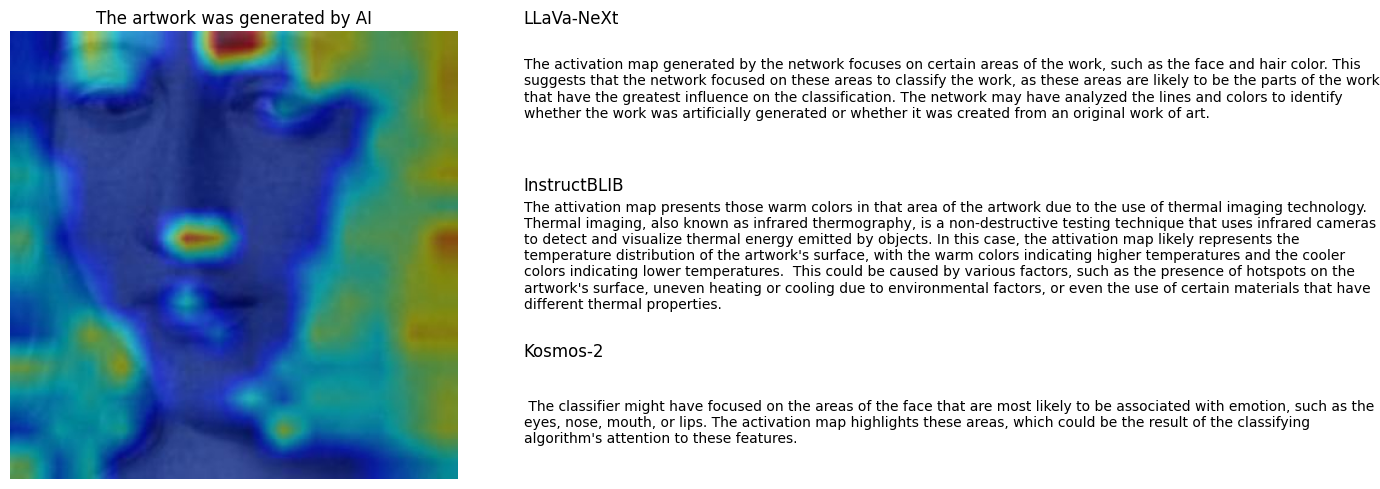

In [ ]:
id = 99
img_url = final_ds.iloc[id]['url_map']
titles = ['LLaVa-NeXt','InstructBLIB','Kosmos-2']
caption = [
    final_ds[final_ds['url_map']== img_url]['LLaVa_desc'].to_numpy()[0],
    final_ds[final_ds['url_map']== img_url]['InstructBLIB_desc'].to_numpy()[0],
    final_ds[final_ds['url_map']== img_url]['Kosmos_desc'].to_numpy()[0]
    ]
label = final_ds[final_ds['url_map']== img_url]['label'].to_numpy()[0]

display_image_with_captions(img_url,caption,titles,label)

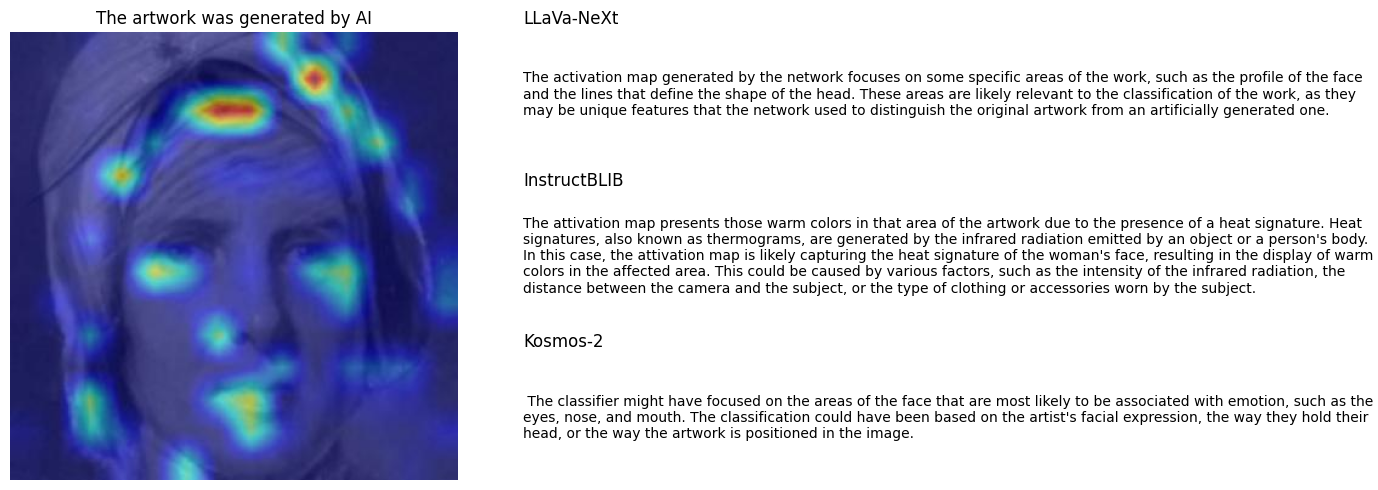

In [ ]:
id = 97
img_url = final_ds.iloc[id]['url_map']
titles = ['LLaVa-NeXt','InstructBLIB','Kosmos-2']
caption = [
    final_ds[final_ds['url_map']== img_url]['LLaVa_desc'].to_numpy()[0],
    final_ds[final_ds['url_map']== img_url]['InstructBLIB_desc'].to_numpy()[0],
    final_ds[final_ds['url_map']== img_url]['Kosmos_desc'].to_numpy()[0]
    ]
label = final_ds[final_ds['url_map']== img_url]['label'].to_numpy()[0]

display_image_with_captions(img_url,caption,titles,label)

## Original artwork

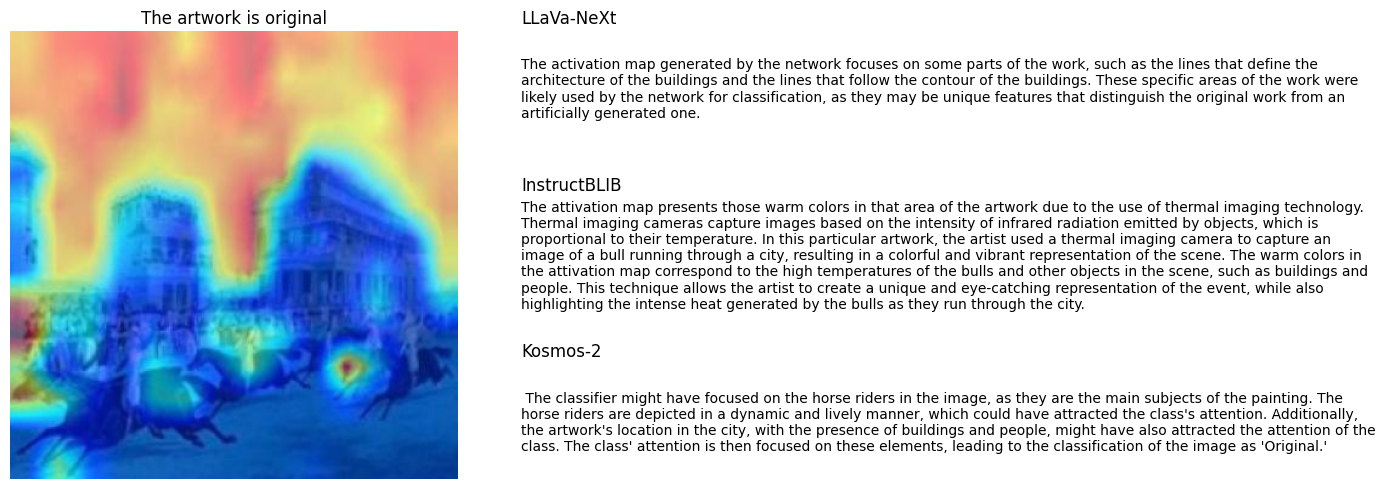

In [ ]:
id = 18
img_url = final_ds.iloc[id]['url_map']
titles = ['LLaVa-NeXt','InstructBLIB','Kosmos-2']
caption = [
    final_ds[final_ds['url_map']== img_url]['LLaVa_desc'].to_numpy()[0],
    final_ds[final_ds['url_map']== img_url]['InstructBLIB_desc'].to_numpy()[0],
    final_ds[final_ds['url_map']== img_url]['Kosmos_desc'].to_numpy()[0]
    ]
label = final_ds[final_ds['url_map']== img_url]['label'].to_numpy()[0]

display_image_with_captions(img_url,caption,titles,label)

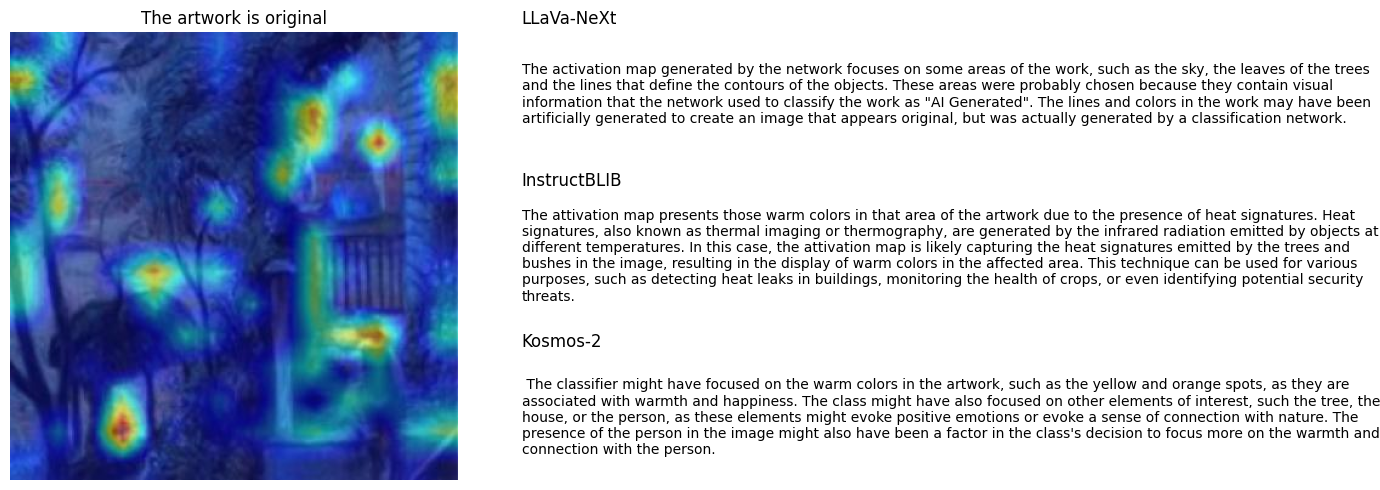

In [ ]:
id = 29
img_url = final_ds.iloc[id]['url_map']
titles = ['LLaVa-NeXt','InstructBLIB','Kosmos-2']
caption = [
    final_ds[final_ds['url_map']== img_url]['LLaVa_desc'].to_numpy()[0],
    final_ds[final_ds['url_map']== img_url]['InstructBLIB_desc'].to_numpy()[0],
    final_ds[final_ds['url_map']== img_url]['Kosmos_desc'].to_numpy()[0]
    ]
label = final_ds[final_ds['url_map']== img_url]['label'].to_numpy()[0]

display_image_with_captions(img_url,caption,titles,label)